<a href="https://colab.research.google.com/github/mrsbelema/belema/blob/main/stud_perf_prediction_belema_kio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required imports
! pip install pandas pgmpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Load the data
data = pd.read_csv('///content/xAPI-Edu-Data.csv')

# Display the first few rows of the dataset
print(data.head())

  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Yes                     Go

In [ ]:
# Data Exploration and Understanding
# Descriptive statistics
desc_stats = data.describe()
print("Descriptive Statistics:\n", desc_stats)

Descriptive Statistics:
        raisedhands  VisITedResources  AnnouncementsView  Discussion
count   480.000000        480.000000         480.000000  480.000000
mean     46.775000         54.797917          37.918750   43.283333
std      30.779223         33.080007          26.611244   27.637735
min       0.000000          0.000000           0.000000    1.000000
25%      15.750000         20.000000          14.000000   20.000000
50%      50.000000         65.000000          33.000000   39.000000
75%      75.000000         84.000000          58.000000   70.000000
max     100.000000         99.000000          98.000000   99.000000


In [ ]:

# Check for missing values
missing_values = data.isna().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64


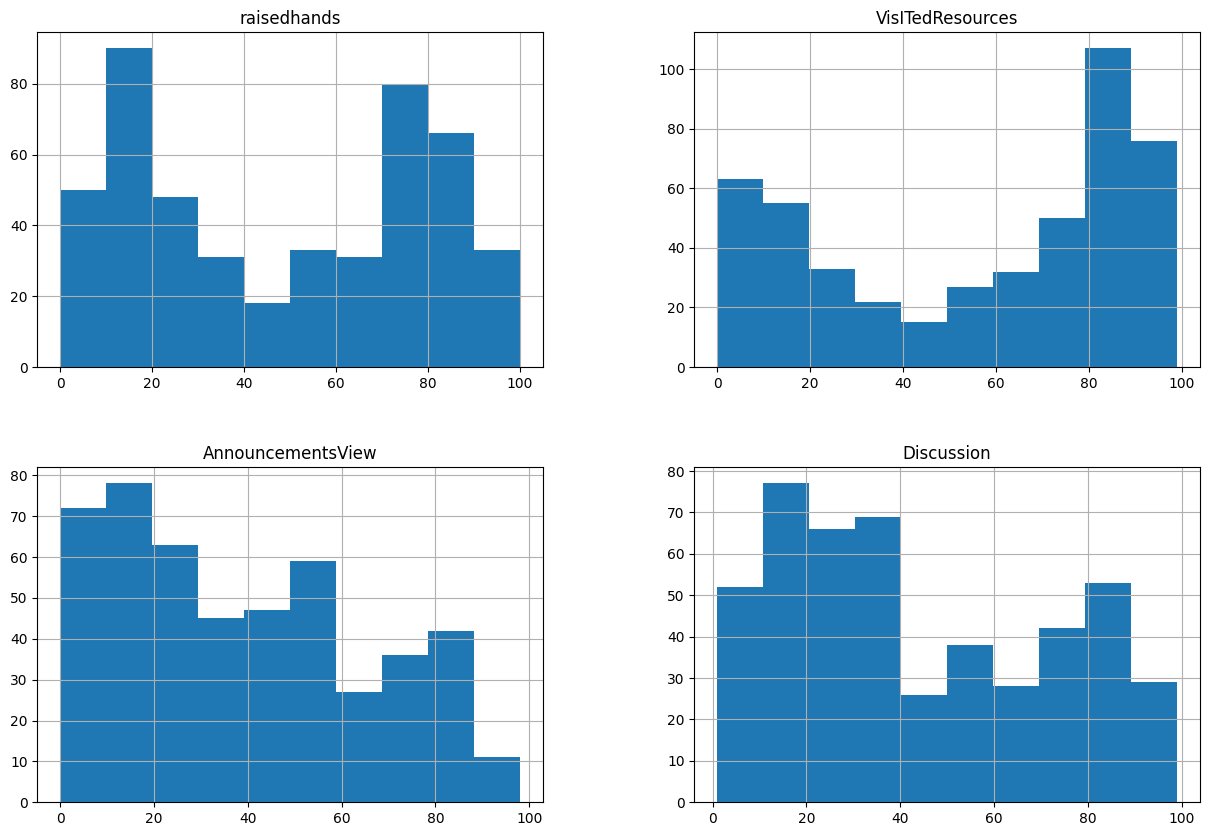

In [ ]:
# Visualizations
# Plot histograms for numerical variables
data.hist(figsize=(15, 10))
plt.show()

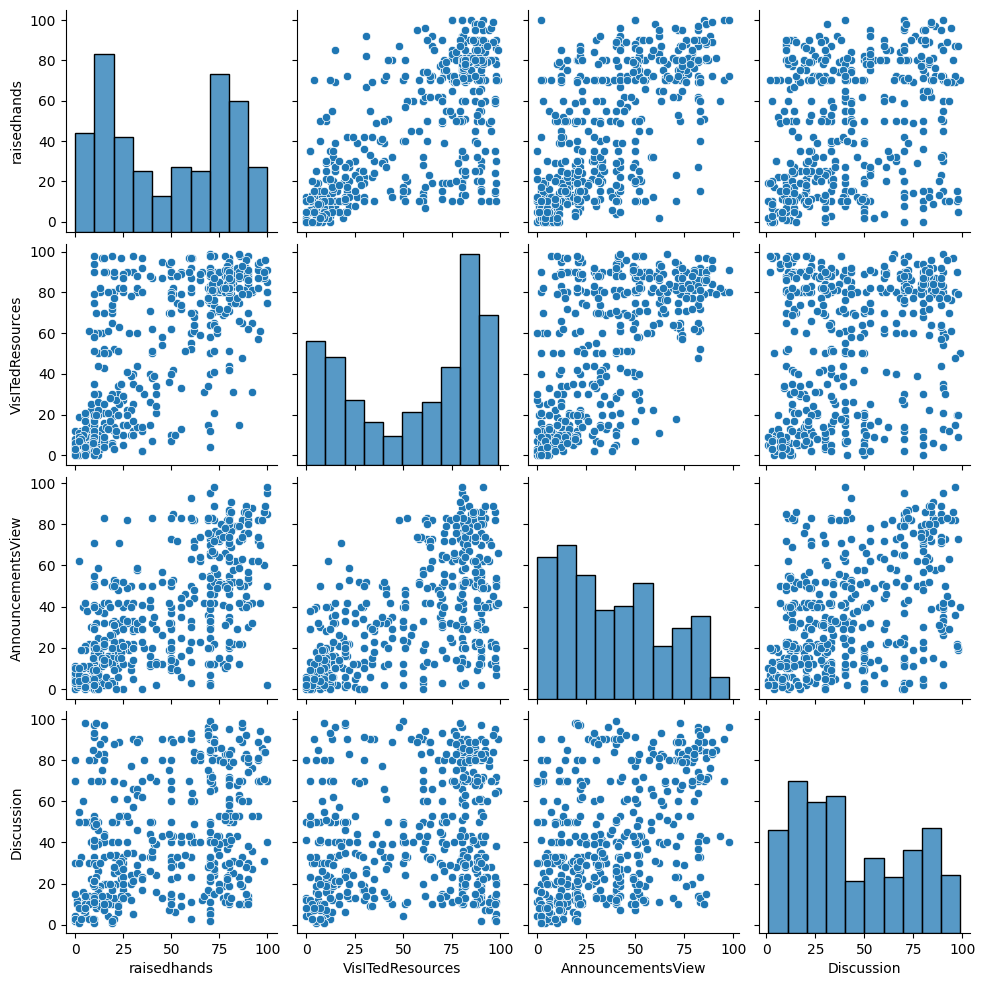

In [ ]:
# Pairplot to visualize relationships
sns.pairplot(data)
plt.show()

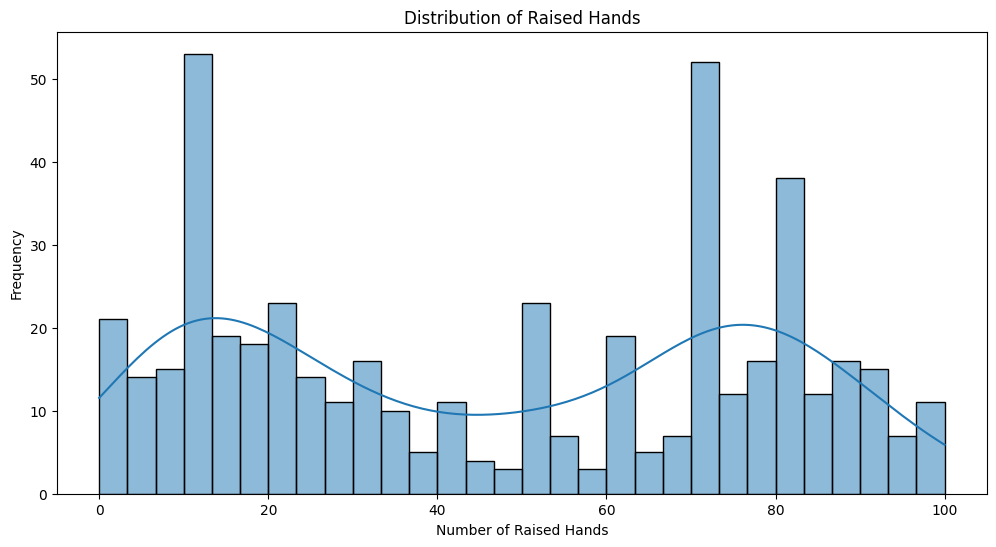

In [ ]:
# Plot distribution of key variables
plt.figure(figsize=(12, 6))
sns.histplot(data['raisedhands'], bins=30, kde=True)
plt.title('Distribution of Raised Hands')
plt.xlabel('Number of Raised Hands')
plt.ylabel('Frequency')
plt.show()

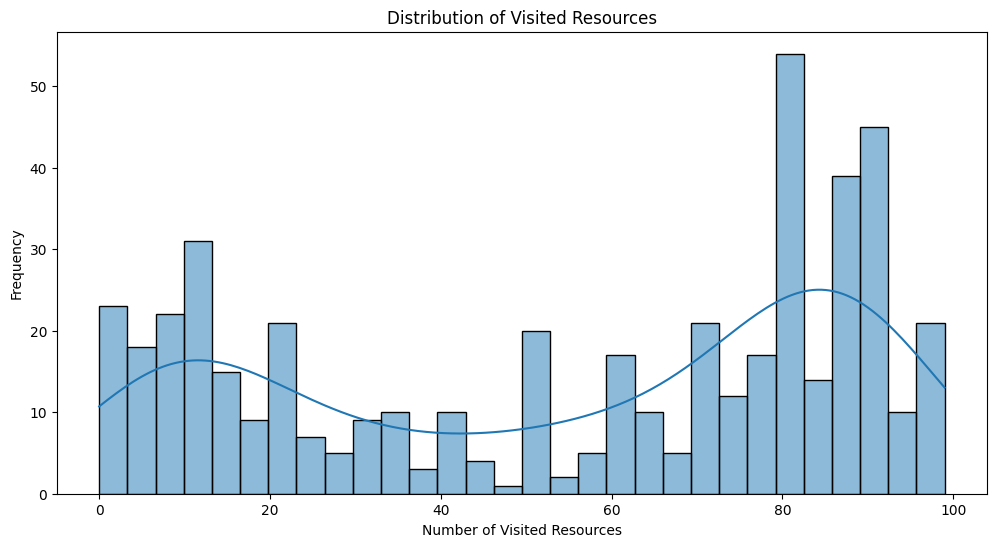

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['VisITedResources'], bins=30, kde=True)
plt.title('Distribution of Visited Resources')
plt.xlabel('Number of Visited Resources')
plt.ylabel('Frequency')
plt.show()

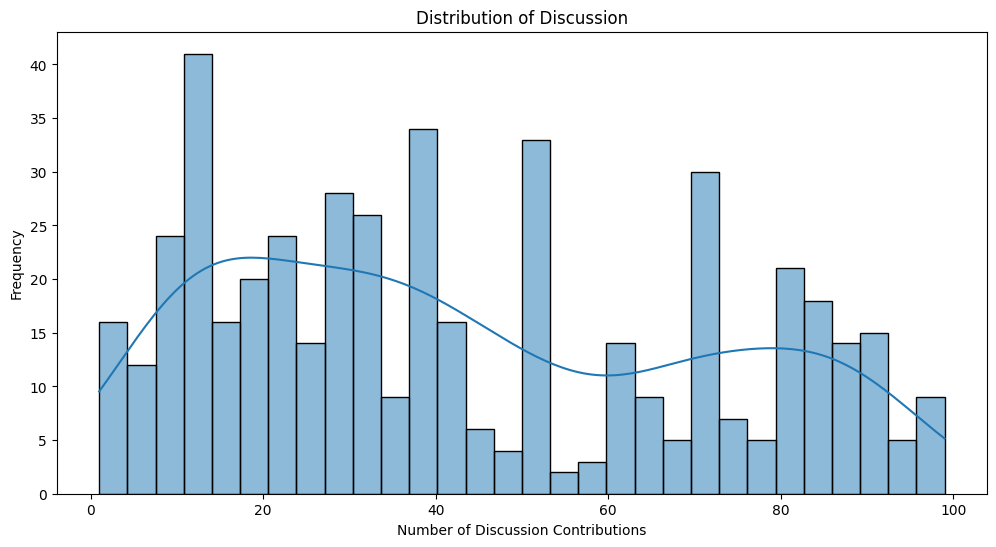

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Discussion'], bins=30, kde=True)
plt.title('Distribution of Discussion')
plt.xlabel('Number of Discussion Contributions')
plt.ylabel('Frequency')
plt.show()

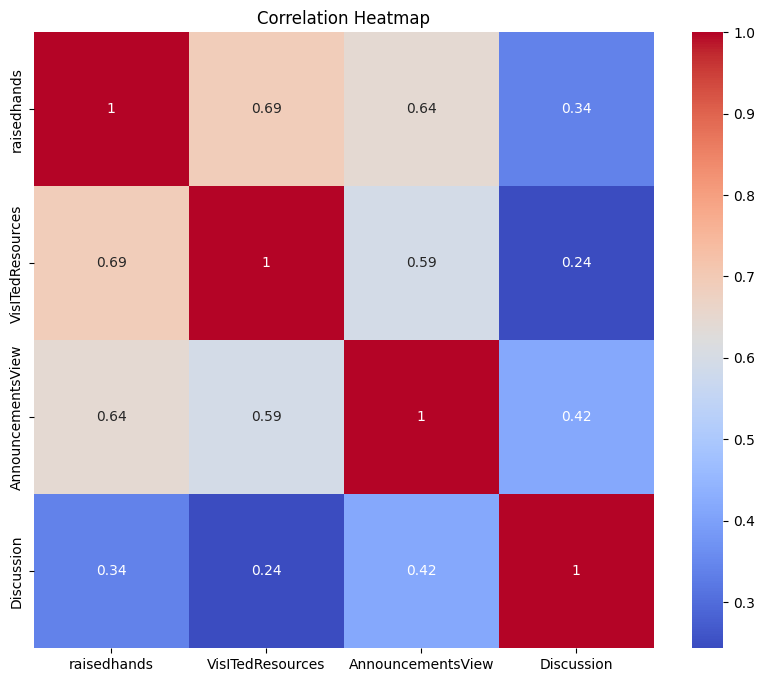

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

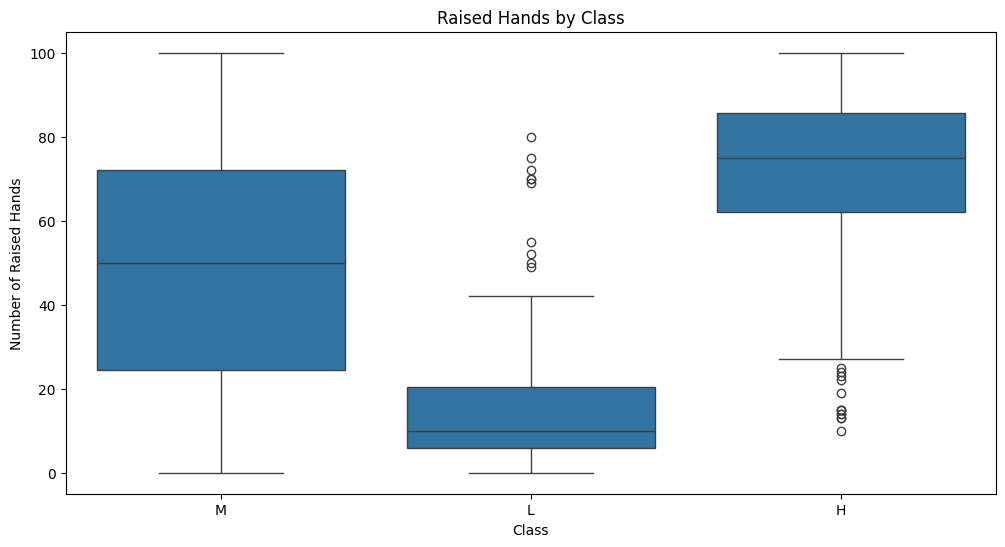

In [ ]:
# Performance metrics by class
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='raisedhands', data=data)
plt.title('Raised Hands by Class')
plt.xlabel('Class')
plt.ylabel('Number of Raised Hands')
plt.show()

In [ ]:
# Data Preprocessing
# Discretize numerical variables
data['raisedhands_disc'] = pd.cut(data['raisedhands'], bins=3, labels=['Low', 'Medium', 'High'])
data['VisITedResources_disc'] = pd.cut(data['VisITedResources'], bins=3, labels=['Low', 'Medium', 'High'])
data['AnnouncementsView_disc'] = pd.cut(data['AnnouncementsView'], bins=3, labels=['Low', 'Medium', 'High'])
data['Discussion_disc'] = pd.cut(data['Discussion'], bins=3, labels=['Low', 'Medium', 'High'])


In [ ]:
# Ensure all relevant columns are encoded (one-hot encoding)
encoded_columns = pd.get_dummies(data).columns.tolist()

# Calculate Pearson correlation for numerical columns
numerical_cols = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
corr_matrix = data[numerical_cols].corr()

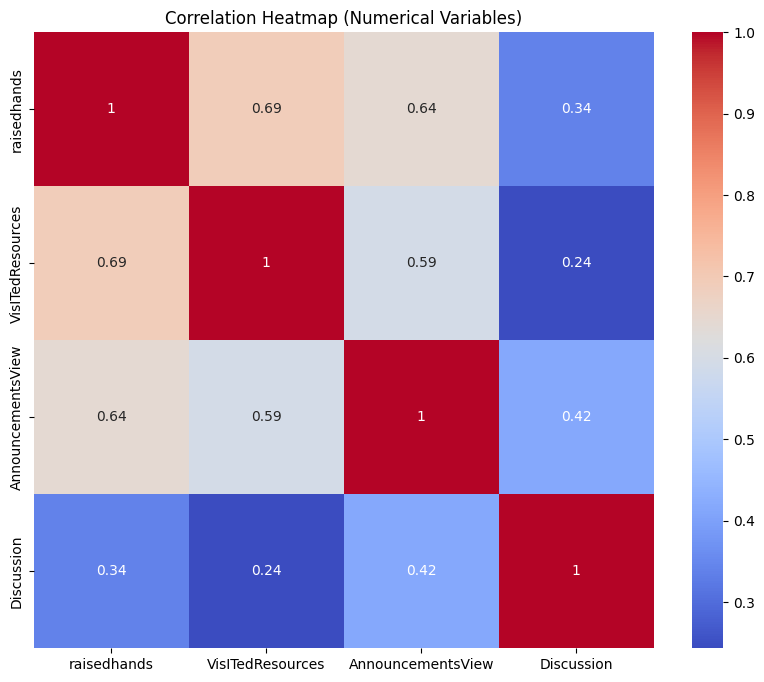

In [ ]:
# Heatmap for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numerical Variables)')
plt.show()


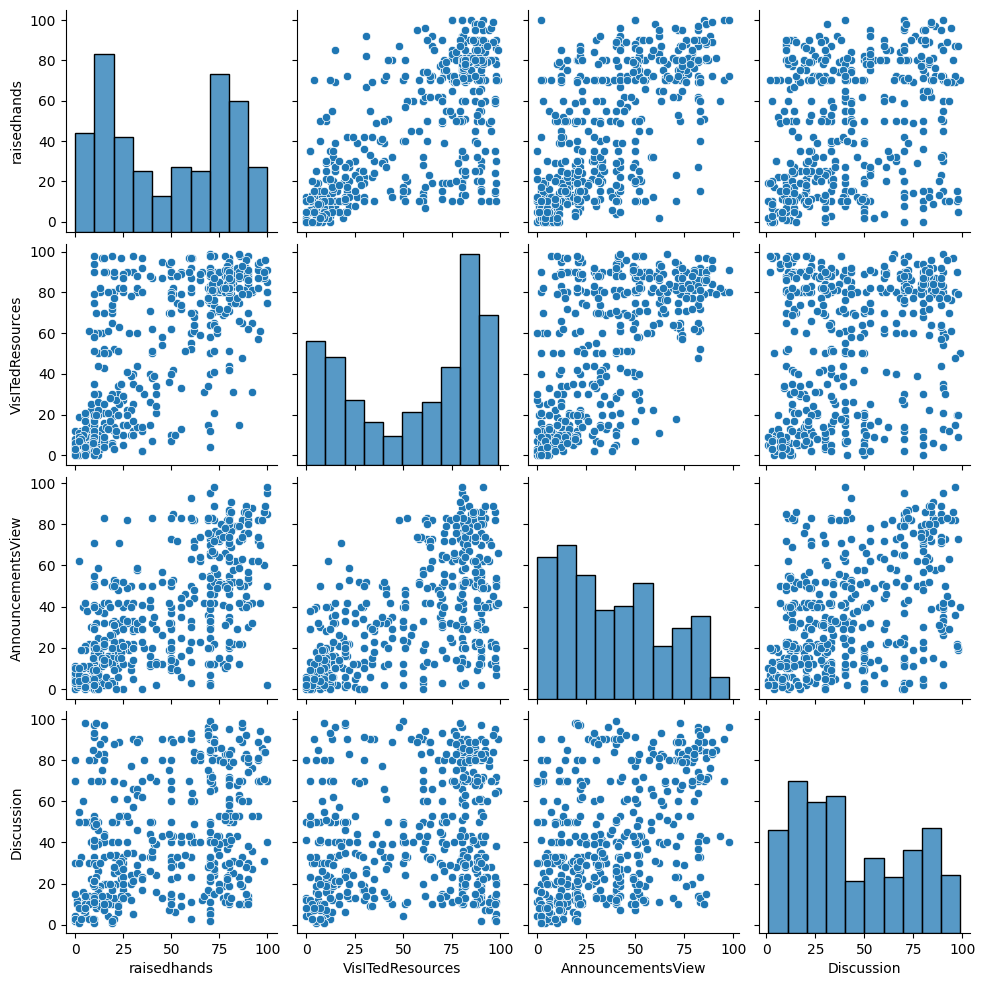

In [ ]:
# Pairplot for visualizing relationships
sns.pairplot(data[numerical_cols])
plt.show()

In [ ]:
# Chi-squared test between 'gender' and 'Class'
contingency_table = pd.crosstab(data['gender'], data['Class'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")


Chi-squared statistic: 33.326236065889375
P-value: 5.79828805474192e-08


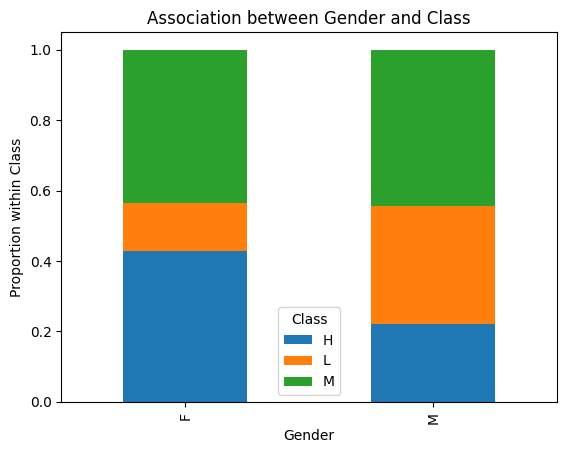

In [ ]:
# Visualize with a stacked bar chart
contingency_table.div(contingency_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Association between Gender and Class')
plt.xlabel('Gender')
plt.ylabel('Proportion within Class')
plt.show()



Inference Query Result:
 +-------------------------------+------------------------------+
| VisITedResources_disc         |   phi(VisITedResources_disc) |
+===============================+==============================+
| VisITedResources_disc(High)   |                       0.4921 |
+-------------------------------+------------------------------+
| VisITedResources_disc(Low)    |                       0.3375 |
+-------------------------------+------------------------------+
| VisITedResources_disc(Medium) |                       0.1704 |
+-------------------------------+------------------------------+


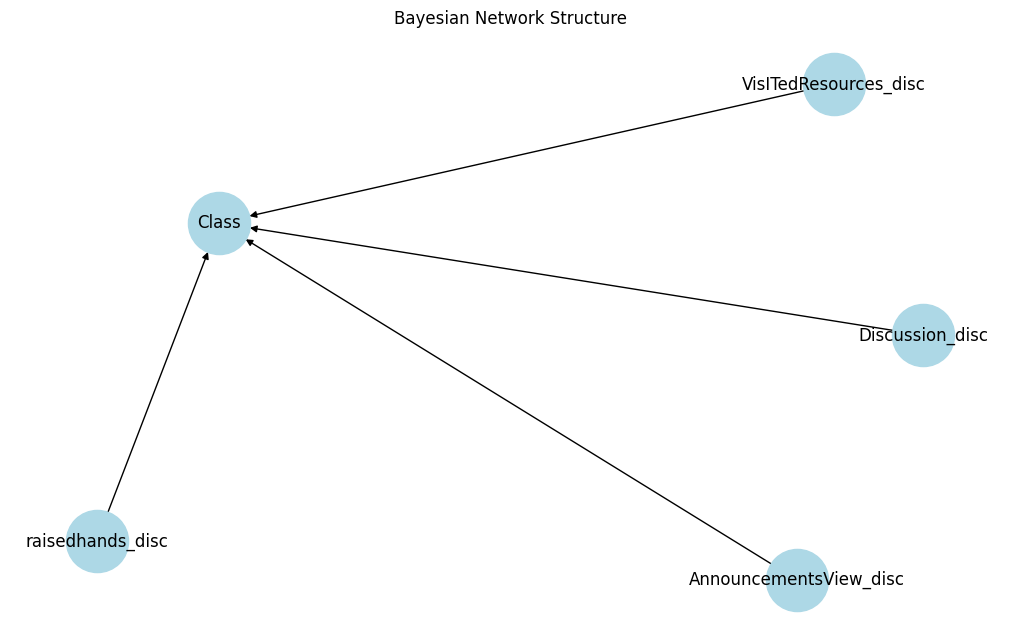

In [ ]:


# Define the structure of the Bayesian Network
edges = [
    ('raisedhands_disc', 'Class'),
    ('VisITedResources_disc', 'Class'),
    ('AnnouncementsView_disc', 'Class'),
    ('Discussion_disc', 'Class')
]

# Create Bayesian Network model
model = BayesianNetwork(edges)

# Fit the model with data using a hybrid approach
# Combine Maximum Likelihood Estimation (MLE) with Bayesian Estimation
model.fit(data, estimator=MaximumLikelihoodEstimator)
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")  # Using BDeu score

# Perform inference with VariableElimination
infer = VariableElimination(model)

# Query the model
query_result = infer.query(variables=['VisITedResources_disc'], evidence={'raisedhands_disc': 'High'})

# Print inference query result
print("\nInference Query Result:\n", query_result)

# Plotting the Bayesian Network structure
G = nx.DiGraph()
G.add_edges_from(edges)

# Specify node positions (optional, for better layout)
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Bayesian Network Structure")
plt.show()


In [ ]:
# Select numerical features for PCA
numerical_features = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
data_numerical = data[numerical_features]

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_numerical)

# Apply PCA
pca = PCA(n_components=2)  # Choose number of components
principal_components = pca.fit_transform(data_standardized)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate PCA results with discretized features
data_pca = pd.concat([data, pca_df], axis=1)

# Define Bayesian Network structure with PCA components
edges = [
    ('raisedhands_disc', 'PC1'),
    ('VisITedResources_disc', 'PC1'),
    ('AnnouncementsView_disc', 'PC2'),
    ('Discussion_disc', 'PC2'),
    ('PC1', 'Class'),
    ('PC2', 'Class')
]

# Create and fit Bayesian Network model (as before)
model = BayesianNetwork(edges)
model.fit(data_pca, estimator=MaximumLikelihoodEstimator)


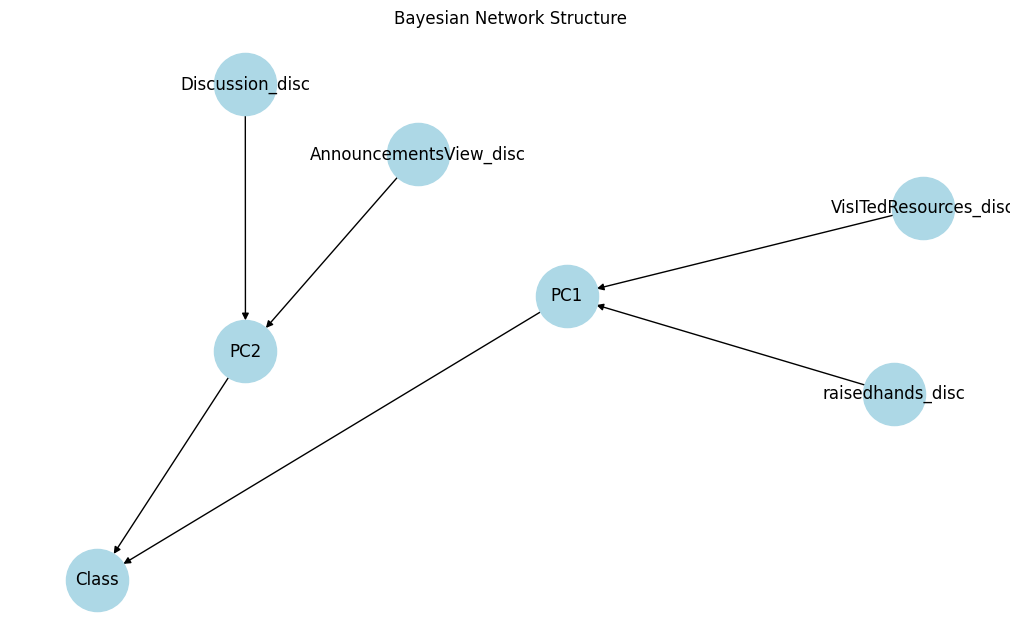

In [ ]:
# Plotting the Bayesian Network structure
G = nx.DiGraph()
G.add_edges_from(edges)

# Specify node positions (optional, for better layout)
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Bayesian Network Structure")
plt.show()